In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import librosa
import librosa.display
import util as ut
import numpy as np
import os
import jams
import matplotlib.pyplot as plt

In [4]:
rc = ut.RockCorpus()

In [68]:
def relative_root(key_output, root_output):
    output = np.zeros(root_output.shape)
    
    root_only = root_output[:, :12] # no N class
    for tonic in range(12):
        rel_root = np.roll(root_only, -tonic, axis=1)
        output[:, :12] += rel_root * key_output[:, tonic]
    
    output[:, 12] = root_output[:, 12]
    return output

def track_root_dist(rel_root):
    out = np.mean(rel_root, axis=0, keepdims=True)
    return np.nan_to_num(out / out.sum()) #really shouldn't be necessary

In [69]:
# bi-gram
def track_root_motion(rel_root):
    root_motion_mat = np.zeros((13,13))
    for f in range(len(rel_root)-1):
        root_motion_mat += np.outer(rel_root[f], rel_root[f+1])
    np.fill_diagonal(root_motion_mat, 0)
    out = root_motion_mat[:12, :12]
    return np.nan_to_num(out / out.sum(axis=1, keepdims=True))

In [70]:
class RCTrackOutputs(object):
    def __init__(self, idx):
        data = np.load(rc.proc_path(0), allow_pickle=True)

        key_output = data['key']
        root_output = data['chord'].item()['chord_root'])

        self.key_output = np.roll(ut.key_marg_add_logit(key_output), -3, axis=1)
        self.root_output = root_output
        
        self.calibrated_key = ut.calibrate_key(key_output)
        self.calibrated_root = ut.calibrate_root(root_output)

        self.hard_key = np.eye(12)[np.argmax(self.key_output, axis=1)]
        self.hard_root = np.eye(13)[np.argmax(self.root_output, axis=1)]

In [71]:
data = np.load(rc.proc_path(0), allow_pickle=True)

track_data = TrackOutputs(key_output=data['key'], 
                          root_output=data['chord'].item()['chord_root'])

In [72]:
rel_root = relative_root(track_data.calibrated_key, track_data.calibrated_root)
rel_root_raw = relative_root(track_data.key_output, track_data.root_output)
rel_root_hard = relative_root(track_data.hard_key, track_data.hard_root)

root_d = track_root_dist(rel_root)
root_d_raw = track_root_dist(rel_root_raw)
root_d_hard = track_root_dist(rel_root_hard)

In [106]:
c_corpus_root_d = []
r_corpus_root_d = []
h_corpus_root_d = []
hkcr_d = []
hkcr_m = []
ckhr_d = []
ckhr_m = []
c_corpus_root_m = []
r_corpus_root_m = []
h_corpus_root_m = []

for i in range(len(rc)):
    data = np.load(rc.proc_path(i), allow_pickle=True)

    track_data = TrackOutputs(key_output=data['key'], 
                              root_output=data['chord'].item()['chord_root'])

    rel_root = relative_root(track_data.calibrated_key, track_data.calibrated_root)
    rel_root_raw = relative_root(track_data.key_output, track_data.root_output)
    rel_root_hard = relative_root(track_data.hard_key, track_data.hard_root)
    rel_root_hkcr = relative_root(track_data.hard_key, track_data.calibrated_root)
    rel_root_ckhr = relative_root(track_data.calibrated_key, track_data.hard_root)

    c_corpus_root_d.append(track_root_dist(rel_root))
    r_corpus_root_d.append(track_root_dist(rel_root_raw))
    h_corpus_root_d.append(track_root_dist(rel_root_hard))
    hkcr_d.append(track_root_dist(rel_root_hkcr))
    ckhr_d.append(track_root_dist(rel_root_ckhr))

    c_corpus_root_m.append(track_root_motion(rel_root))
    r_corpus_root_m.append(track_root_motion(rel_root_raw))
    h_corpus_root_m.append(track_root_motion(rel_root_hard))
    hkcr_m.append(track_root_motion(rel_root_hkcr))
    ckhr_m.append(track_root_motion(rel_root_ckhr))

/scratch/qx244/envs/crema/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [107]:
cm = np.sum(c_corpus_root_m, axis=0) / 200
rm = np.sum(r_corpus_root_m, axis=0) / 200
hm = np.sum(h_corpus_root_m, axis=0) / 200
hkcrm = np.sum(hkcr_m, axis=0) / 200
ckhrm = np.sum(ckhr_m, axis=0) / 200

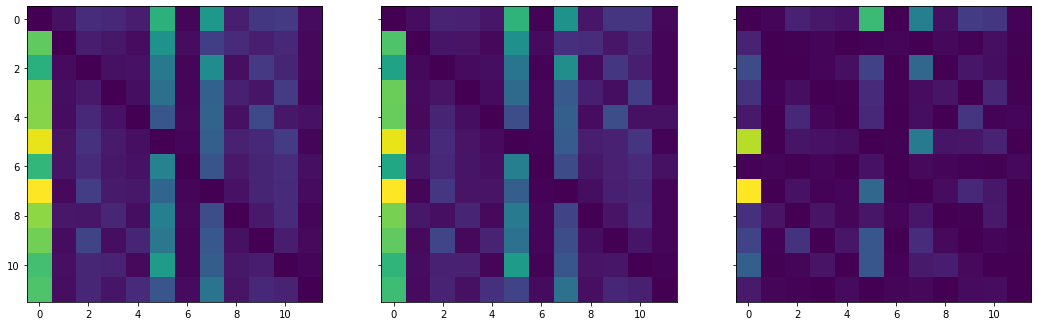

In [75]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                                    figsize=(18, 6))
ax0.imshow(cm)
ax1.imshow(rm)
ax2.imshow(hm)
plt.show()

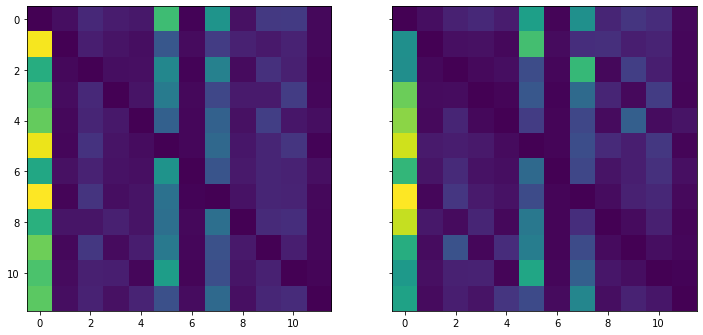

In [108]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                                    figsize=(12, 6))
ax0.imshow(hkcrm)
ax1.imshow(ckhrm)
plt.show()

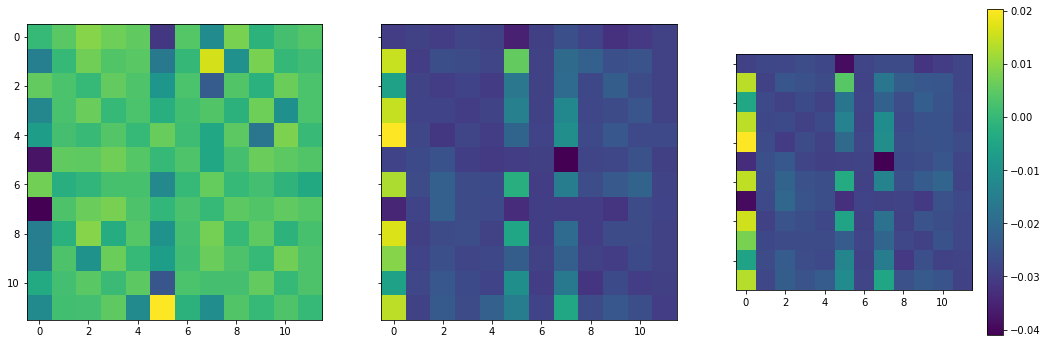

In [93]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                                    figsize=(18, 6))
im0 = ax0.imshow(cm - rm)
im1 = ax1.imshow(rm - hm)
im2 = ax2.imshow(cm - hm)
plt.colorbar(im0)
plt.show()

In [109]:
def interval_motion(motion_mat):
    interval = []
    for idx in range(len(motion_mat)):
        interval.append(np.roll(motion_mat[idx], -idx))
    return np.array(interval)

def plot_int_motion(motion_mat):
    int_motion_d = np.sum(interval_motion(motion_mat), axis=0)
    int_motion_d /= int_motion_d.sum()
    plt.bar(range(12), int_motion_d)

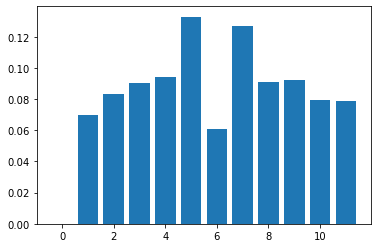

In [113]:
plot_int_motion(cm)

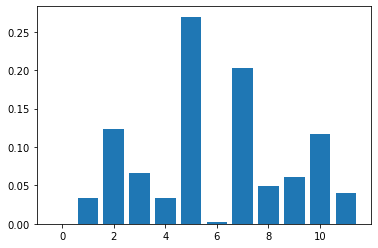

In [114]:
plot_int_motion(hm)

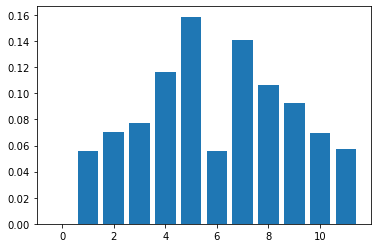

In [111]:
plot_int_motion(ckhrm)

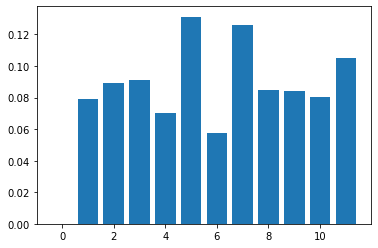

In [112]:
plot_int_motion(hkcrm)

In [76]:
cd = np.sum(c_corpus_root_d, axis=0) / 200
rd = np.sum(r_corpus_root_d, axis=0) / 200
hd = np.sum(h_corpus_root_d, axis=0) / 200

In [123]:
corpus_root_dist = np.array(
    [0.48311937, 0.00182925, 0.0391728 , 0.01097317, 0.01669945,
     0.18386082, 0.00112481, 0.15247715, 0.01958853, 0.05188288,
     0.0375619 , 0.00170987, 0.        ])

<BarContainer object of 13 artists>

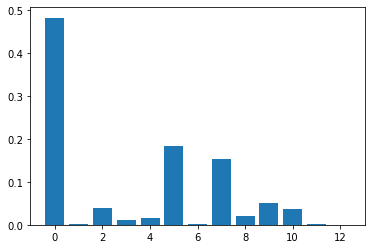

In [124]:
plt.bar(range(13), corpus_root_dist)

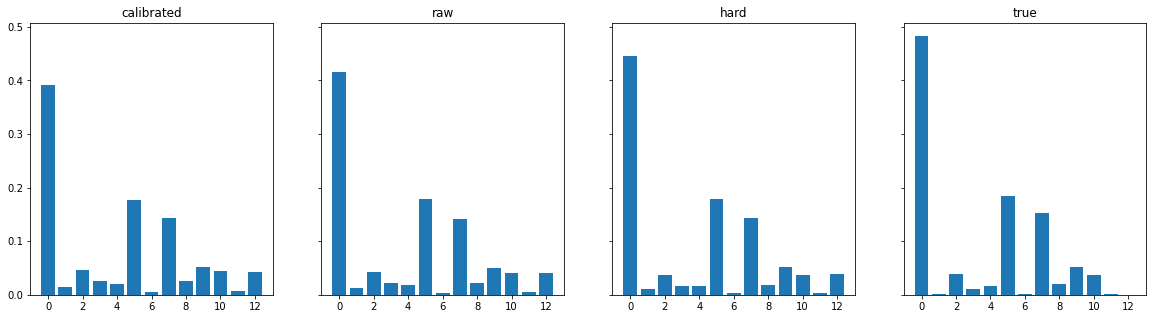

In [155]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True,
                                    figsize=(20, 5))
ax0.bar(range(13), cd[0])
ax0.set(title='calibrated')
ax1.bar(range(13), rd[0])
ax1.set(title='raw')
ax2.bar(range(13), hd[0])
ax2.set(title='hard')
ax3.bar(range(13), corpus_root_dist)
ax3.set(title='true')
plt.show()

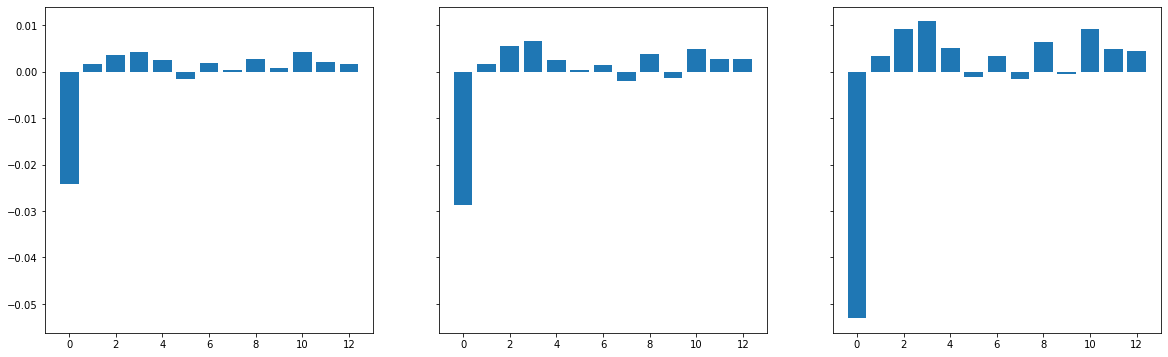

In [83]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                                    figsize=(20, 6))
ax0.bar(range(13), cd[0] - rd[0])
ax1.bar(range(13), rd[0] - hd[0])
ax2.bar(range(13), cd[0] - hd[0])
plt.show()

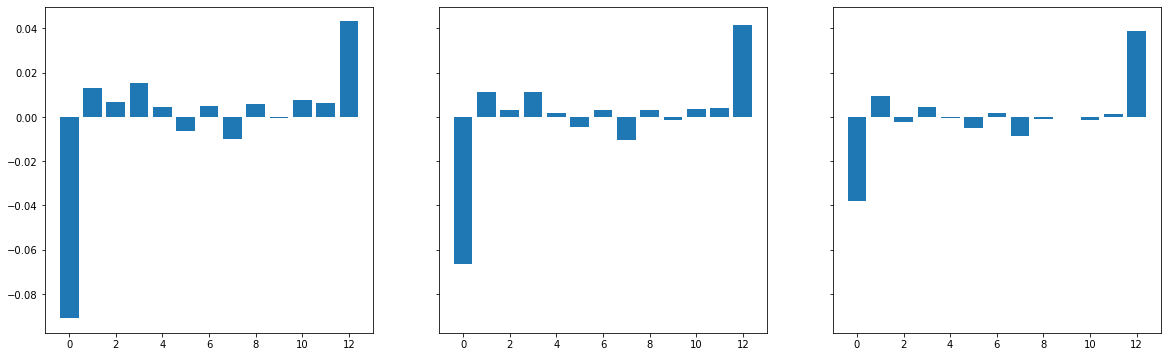

In [125]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                                    figsize=(20, 6))
ax0.bar(range(13), cd[0] - corpus_root_dist)
ax1.bar(range(13), rd[0] - corpus_root_dist)
ax2.bar(range(13), hd[0] - corpus_root_dist)
plt.show()

In [130]:
cd_short = cd[:,:12] / cd[:,:12].sum(axis=1, keepdims=True)
rd_short = rd[:,:12] / rd[:,:12].sum(axis=1, keepdims=True)
hd_short = hd[:,:12] / hd[:,:12].sum(axis=1, keepdims=True)

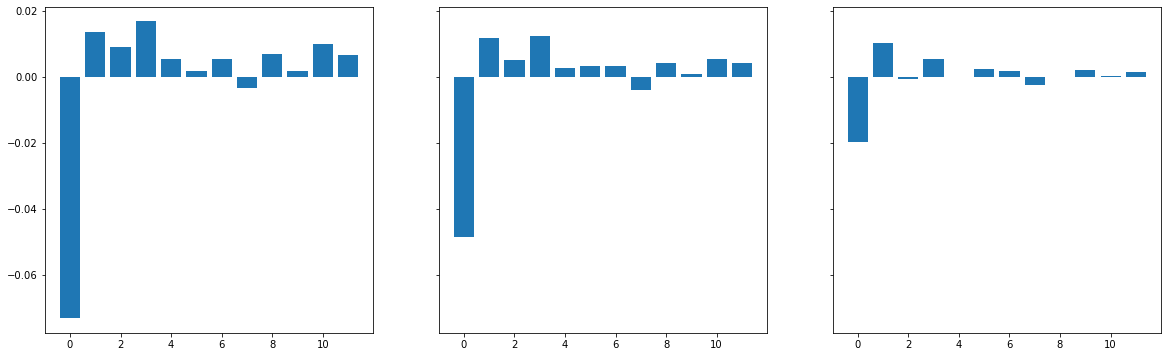

In [131]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                                    figsize=(20, 6))
ax0.bar(range(12), cd_short[0] - corpus_root_dist[:12])
ax1.bar(range(12), rd_short[0] - corpus_root_dist[:12])
ax2.bar(range(12), hd_short[0] - corpus_root_dist[:12])
plt.show()

In [126]:
cd_loss = np.abs(cd[0] - corpus_root_dist).sum()
rd_loss = np.abs(rd[0] - corpus_root_dist).sum()
hd_loss = np.abs(hd[0] - corpus_root_dist).sum()
(cd_loss, rd_loss, hd_loss)

(0.21495237759497132, 0.16582417256043225, 0.1121439283763475)

In [ ]:
librosa.display.specshow(rel_root.T, 
                         sr=44100, 
                         hop_length=4096, 
                         x_axis='time', 
                         y_axis='chroma')

In [44]:
mat = track_root_motion(rel_root)

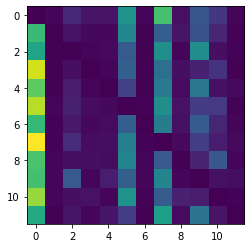

In [46]:
plt.imshow(mat)

In [200]:
track_id = 150

data = np.load(rc.proc_path(track_id), allow_pickle=True)

track_data = TrackOutputs(key_output=data['key'], 
                          root_output=data['chord'].item()['chord_root'])

In [201]:
rc.titles[track_id]

'thats_all_right'

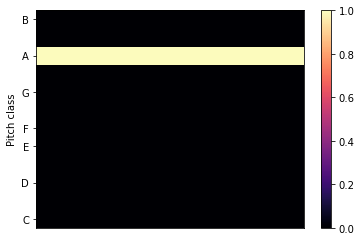

In [202]:
librosa.display.specshow(track_data.key_output.T, y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()

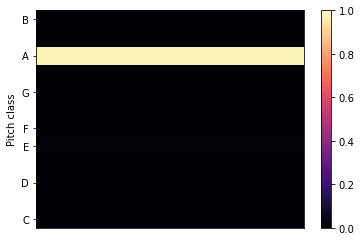

In [203]:
librosa.display.specshow(track_data.calibrated_key.T, y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()

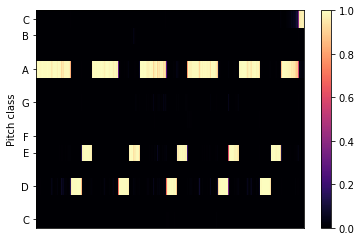

In [204]:
librosa.display.specshow(track_data.root_output.T, y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()

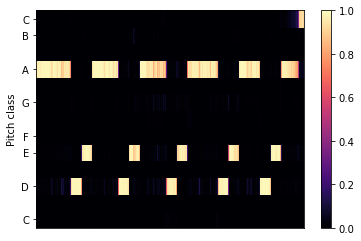

In [205]:
librosa.display.specshow(track_data.calibrated_root.T, y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()


In [206]:
mat = relative_root(track_data.calibrated_key, track_data.calibrated_root)
mat.shape

(1258, 13)

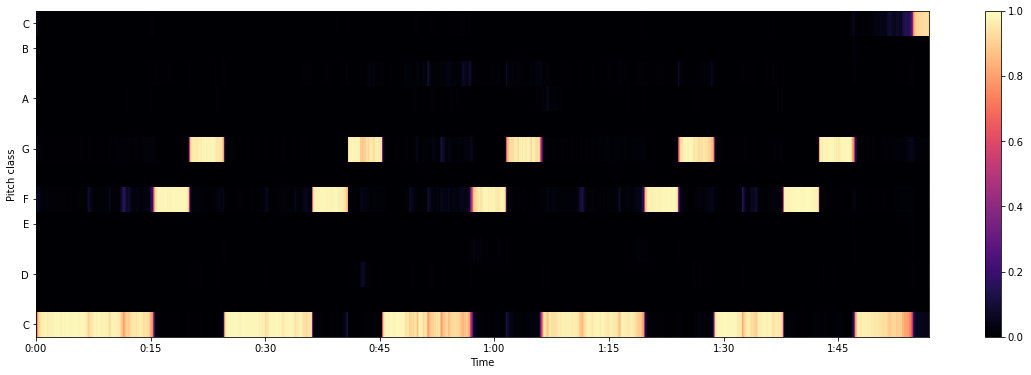

In [207]:
plt.figure(figsize=(20,6))
librosa.display.specshow(relative_root(track_data.hard_key, track_data.calibrated_root).T, y_axis='chroma', vmin=0, vmax=1, x_axis='time', sr=44100, hop_length=4096)
plt.colorbar()

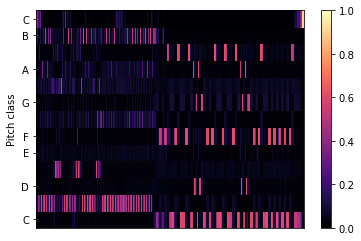

In [195]:
librosa.display.specshow(mat.T, y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()

In [178]:
np.sum(mat, axis=1)

array([1.00000004, 0.99999997, 1.00000008, ..., 1.00000008, 0.99999997,
       1.00000003])

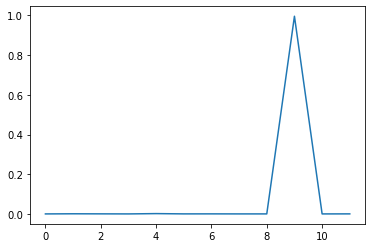

In [159]:
plt.plot(track_data.calibrated_key.T)